# Logistic Regression (NumPy Implementation)

This notebook demonstrates logistic regression implemented from scratch using NumPy, providing a hands-on translation of the underlying mathematics into code. 
Unlike using scikit-learn’s built-in models, this approach exposes the full computation process, from cost calculation to gradient descent updates. 
It also complements the theory notes in `theory/logistic_regression_math.md`, creating a clear bridge from **mathematical concepts** → **algorithmic implementation** → **model results**.

## Scenario: Student Performance Prediction

To make the implementation concrete, we use a synthetic dataset representing **students preparing for an exam**.  
The features include:
- Age  
- Study hours per day  
- Attendance percentage  
- Class participation level  
- Average sleep hours  

We consider two prediction tasks:

1. **Binary Logistic Regression**:  
   Predict whether a student will **pass (1)** or **fail (0)** the exam.  

2. **Multiclass Logistic Regression**:  
   Predict the performance group a student belongs to:  
   - **Class 0** → Low performers (likely to fail)  
   - **Class 1** → Average performers (borderline pass)  
   - **Class 2** → High performers (likely to excel)  

This way, we can see how logistic regression handles both binary and multiclass classification using the same underlying principles.

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

## Helper Function

In [2]:
def generate_student_data(m = 2000, num_classes = 2, random_state = 42):
    """
    Generate synthetic student performance data.
    
    Parameters
    ----------
    m : int
        Number of examples (students).
    num_classes : int
        2 = binary (pass/fail), >2 = multiclass (performance groups).
    random_state : int
        Random seed for reproducibility.
    
    Returns
    -------
    df : pandas.DataFrame
        Dataset with features and labels.
    X : np.ndarray
        Standardized feature matrix.
    y : np.ndarray
        Labels (0/1 for binary, class indices for multiclass).
    """
    np.random.seed(random_state)

    # Features
    age = np.random.randint(18, 25, m)
    study_hours = np.random.randint(1, 20, m)
    attendance = np.random.randint(50, 101, m)
    participation = np.random.randint(1, 5, m)
    sleep_hours = np.random.randint(2, 9, m)

    feature_names = ["age", "study_hours", "attendance", "participation", "sleep_hours"]

    # Standardize features
    scaler = StandardScaler()
    raw_data = np.column_stack([age, study_hours, attendance, participation, sleep_hours])
    X = scaler.fit_transform(raw_data)

    if num_classes == 2:
        # Binary classification
        assigned_weights = [-0.3, 1.2, 0.8, 0.5, 0.4]
        bias = -0.5

        z = np.dot(X, assigned_weights) + bias
        prob = 1 / (1 + np.exp(-z))
        y = (prob > 0.5).astype(int)

    else:
        # Multiclass classification
        assigned_weights = np.array([
            [-0.3,  1.2,  0.8,  0.5,  0.4],  # Class 0
            [ 0.5, -0.8,  0.2, -0.3,  0.1],  # Class 1
            [ 0.1,  0.3, -0.5,  0.2, -0.1]   # Class 2
        ])
        bias = np.array([-0.5, 0.2, 0.1])

        z = np.dot(X, assigned_weights.T) + bias
        exp_z = np.exp(z)  
        prob = exp_z / np.sum(exp_z, axis = 1, keepdims = True)
        y = np.argmax(prob, axis=1)

    # Compile into DataFrame
    df = pd.DataFrame(
        data = np.column_stack([raw_data, y]),
        columns = feature_names + ["labels"])

    return df, X, y

## Binary Logistic Regression - Example Scenario

### Generate synthetic data

In [3]:
df, X, y = generate_student_data(m = 2000, num_classes = 2, random_state = 42)

### Understanding data

In [4]:
df

,age,study_hours,attendance,participation,sleep_hours,labels
0,24,8,59,2,6,0
1,21,13,85,3,7,1
2,22,19,86,1,5,1
3,24,3,77,2,6,0
4,20,8,77,2,3,0
...,...,...,...,...,...,...
1995,21,17,50,2,8,1
1996,22,18,100,2,8,1
1997,22,12,85,2,3,0
1998,18,9,73,2,3,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            2000 non-null   int32
 1   study_hours    2000 non-null   int32
 2   attendance     2000 non-null   int32
 3   participation  2000 non-null   int32
 4   sleep_hours    2000 non-null   int32
 5   labels         2000 non-null   int32
dtypes: int32(6)
memory usage: 47.0 KB


In [6]:
df.describe()

,age,study_hours,attendance,participation,sleep_hours,labels
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,20.967000,9.984000,75.050000,2.485000,4.985500,0.379000
std,2.014433,5.467329,14.727897,1.105616,1.992806,0.485259
min,18.000000,1.000000,50.000000,1.000000,2.000000,0.000000
25%,19.000000,5.000000,62.000000,2.000000,3.000000,0.000000
50%,21.000000,10.000000,75.000000,2.000000,5.000000,0.000000
75%,23.000000,15.000000,88.000000,3.000000,7.000000,1.000000
max,24.000000,19.000000,100.000000,4.000000,8.000000,1.000000


### NumPy Implementation

The binary cross-entropy loss:

$$
J(w,b) = -\frac{1}{m}\sum_{i=1}^m \Big[ y^{(i)}\log\hat{y}^{(i)} + (1-y^{(i)})\log(1-\hat{y}^{(i)}) \Big]
$$

In [7]:
# Cost Function
def compute_cost(X, y, w, b):
    """
    Compute logistic regression cost function (binary cross-entropy).
    
    Parameters
    ----------
    X : np.ndarray, shape (m, n)
        Feature matrix where m = number of examples, n = number of features.
    y : np.ndarray, shape (m,)
        True labels (0 or 1).
    w : np.ndarray, shape (n,)
        Weight vector.
    b : float
        Bias term.
    
    Returns
    -------
    cost : float
        Average logistic regression loss over all examples.
    
    Notes
    -----
    - For each example i:
        zᵢ = X[i]·w + b
        ŷᵢ = sigmoid(zᵢ) = 1 / (1 + exp(-zᵢ))
        lossᵢ = - yᵢ log(ŷᵢ) - (1 - yᵢ) log(1 - ŷᵢ)
    
    - The final cost is the mean of all individual losses:
        J(w, b) = (1/m) Σ lossᵢ
    """
    z = np.dot(X, w) + b
    y_hat = 1 / (1 + np.exp(-z))
    cost = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return cost

In [8]:
w_initial = np.zeros(5)
b_initial = 0.0

X = df.iloc[:, :5].to_numpy()
y = df.iloc[:, -1].to_numpy()

compute_cost(X, y, w_initial, b_initial)

0.6931471805599454

This output represents the initial cost of the binary logistic regression model when all weights and biases are set to zero and no training has been done yet.

Gradients:

$$
\frac{\partial J}{\partial w_j} = \frac{1}{m} \sum_{i=1}^m \big( \hat{y}^{(i)} - y^{(i)} \big) x_j^{(i)}
$$

$$
\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m \big( \hat{y}^{(i)} - y^{(i)} \big)
$$

Gradient Update:

$$
w_j := w_j - \alpha \frac{\partial J}{\partial w_j}, \quad
b := b - \alpha \frac{\partial J}{\partial b}
$$

In [9]:
# Gradient Descent Function
def gradient_update(X, y, w, b, alpha, num_iters):
    """
    Perform gradient descent for binary logistic regression.

    Parameters
    ----------
    X : np.ndarray, shape (m, n)
        Feature matrix with m examples and n features.
    y : np.ndarray, shape (m,)
        True binary labels (0 or 1).
    w : np.ndarray, shape (n,)
        Weight vector.
    b : float
        Bias term.
    alpha : float
        Learning rate.
    num_iters : int
        Number of iterations to run gradient descent.

    Returns
    -------
    w : np.ndarray
        Updated weight vector after training.
    b : float
        Updated bias term.
    cost_hist : list of floats
        Cost values recorded at each iteration.
    """
    m, n = X.shape
    cost_hist = []

    for _ in range(num_iters):
        z = np.dot(X, w) + b              
        y_pred = 1 / (1 + np.exp(-z))     

        # Compute error
        err = y_pred - y                  

        # Compute gradients
        w_grad = (1/m) * np.dot(X.T, err) 
        b_grad = (1/m) * np.sum(err)      

        # Update weights
        w = w - alpha * w_grad
        b = b - alpha * b_grad

        # Compute cost
        cost = compute_cost(X, y, w, b)
        cost_hist.append(cost)

        if _ % 1000 == 0 or _ == (num_iters - 1):
            print(f"{'Iteration':<10}: {_:<4} | {'Cost':<5}: {cost:<4.2f}")

    return w, b, cost_hist

In [10]:
w_initial = np.zeros(5)
b_initial = 0.0

scaler = StandardScaler()
X = scaler.fit_transform(df.iloc[:, :5].to_numpy())
y = df.iloc[:, -1].to_numpy()

w_final, b_final, cost_hist = gradient_update(X, y, w_initial, b_initial, 0.01, 10000)

print("Final Parameters:")
print(f"w: {w_final}")
print(f"b: {b_final:.4f}")

Iteration : 0    | Cost : 0.69
Iteration : 1000 | Cost : 0.27
Iteration : 2000 | Cost : 0.20
Iteration : 3000 | Cost : 0.17
Iteration : 4000 | Cost : 0.15
Iteration : 5000 | Cost : 0.14
Iteration : 6000 | Cost : 0.13
Iteration : 7000 | Cost : 0.12
Iteration : 8000 | Cost : 0.12
Iteration : 9000 | Cost : 0.11
Iteration : 9999 | Cost : 0.11
Final Parameters:
w: [-0.97313945  3.81308852  2.44352984  1.56999272  1.23914417]
b: -1.5689


After running gradient descent, the output shows the optimized weights and bias learned by the binary logistic regression model. These final parameters are what the model will use to make predictions, and they can be compared against the initial zero values to see how the training process adjusted them.

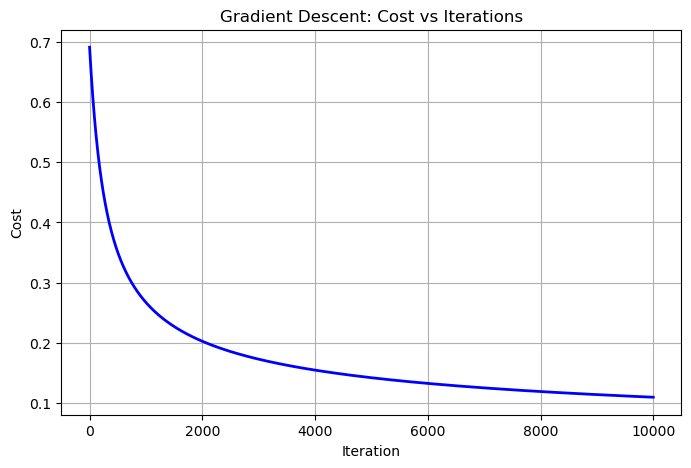

In [11]:
iterations = list(range(len(cost_hist)))  # x-axis
costs = cost_hist                         # y-axis

plt.figure(figsize = (8, 5))
plt.plot(iterations, costs, color = 'blue', linewidth = 2)
plt.title("Gradient Descent: Cost vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

The cost curve drops quickly at the start, showing that gradient descent makes big improvements early on. Around iteration ~2000, there’s an elbow where the cost still decreases but at a much slower rate, meaning the model is approaching its optimal parameters and further learning gives diminishing returns.

### Model Performance

In [12]:
# Prediction Function
def predict(X, w, b):
    z = np.dot(X, w) + b
    y_prob = 1 / (1 + np.exp(-z))
    y_pred = (y_prob > 0.5).astype(int)
    return y_pred

In [13]:
y_pred = predict(X, w_final, b_final)

accuracy = np.mean(y_pred == y)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 99.20%


Using the final trained weights and bias, the model predicts the labels which are matched to the true values using the evaluation metric of accuracy. The result shows that 99.2 % of predictions match with the actual values.

## MultiClass Logistic Regression - Example Scenario

### Generate synthetic data

In [14]:
df, X, y = generate_student_data(m = 2000, num_classes = 3, random_state = 42)

### Understanding data

In [15]:
df

,age,study_hours,attendance,participation,sleep_hours,labels
0,24,8,59,2,6,1
1,21,13,85,3,7,0
2,22,19,86,1,5,0
3,24,3,77,2,6,1
4,20,8,77,2,3,1
...,...,...,...,...,...,...
1995,21,17,50,2,8,2
1996,22,18,100,2,8,0
1997,22,12,85,2,3,1
1998,18,9,73,2,3,2


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   age            2000 non-null   int64
 1   study_hours    2000 non-null   int64
 2   attendance     2000 non-null   int64
 3   participation  2000 non-null   int64
 4   sleep_hours    2000 non-null   int64
 5   labels         2000 non-null   int64
dtypes: int64(6)
memory usage: 93.9 KB


In [17]:
df.describe()

,age,study_hours,attendance,participation,sleep_hours,labels
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,20.967000,9.984000,75.050000,2.485000,4.985500,1.010500
std,2.014433,5.467329,14.727897,1.105616,1.992806,0.745431
min,18.000000,1.000000,50.000000,1.000000,2.000000,0.000000
25%,19.000000,5.000000,62.000000,2.000000,3.000000,0.000000
50%,21.000000,10.000000,75.000000,2.000000,5.000000,1.000000
75%,23.000000,15.000000,88.000000,3.000000,7.000000,2.000000
max,24.000000,19.000000,100.000000,4.000000,8.000000,2.000000


### NumPy Implementation

$$
\hat{y}_c^{(i)} = \frac{e^{z_c}}{\sum_{j=1}^{k} e^{z_j}}
$$

$$
L(\hat{\mathbf{y}}^{(i)}, \mathbf{y}^{(i)}) = - \sum_{c=1}^{k} y^{(i)}_c \, \log \hat{y}^{(i)}_c
$$

$$
J(W, \mathbf{b}) = -\frac{1}{m} \sum_{i=1}^m \sum_{c=1}^k y_c^{(i)} \log \hat{y}_c^{(i)} = -\frac{1}{m} \sum_{i=1}^m L(\hat{\mathbf{y}}^{(i)}, \mathbf{y}^{(i)})
$$

In [18]:
# Cost Function
def compute_cost(X, y, w, b):
    """
    Compute multiclass logistic regression cost (cross-entropy with softmax).

    Parameters
    ----------
    X : np.ndarray, shape (m, n)
        Feature matrix with m examples and n features.
    y : np.ndarray, shape (m, k)
        One-hot encoded true labels (k = number of classes).
    w : np.ndarray, shape (k, n)
        Weight matrix for each class.
    b : np.ndarray, shape (k,)
        Bias vector for each class.

    Returns
    -------
    cost : float
        Average cross-entropy loss over all examples.
    """
    m, n = X.shape
    z = np.dot(X, w.T) + b
    y_hat = np.exp(z) / np.sum(np.exp(z), axis = 1, keepdims = True)
    cost = -np.sum(y_onehot * np.log(y_hat)) / m
    return cost

In [19]:
w_initial = np.zeros((3, 5))
b_initial = np.zeros(3)

X = df.iloc[:, :5].to_numpy()

# Initialize encoder
encoder = OneHotEncoder(sparse_output = False)

y = df.iloc[:, -1].to_numpy().reshape(-1, 1)

# Fit and transform labels
y_onehot = encoder.fit_transform(y)

compute_cost(X, y_onehot, w_initial, b_initial)

1.0986122886681096

This output represents the initial cost of the multiclass logistic regression model when all weights and biases are set to zero and no training has been done yet.

Gradients:

$$
\frac{\partial J}{\partial W} = \frac{1}{m} (\hat{Y} - Y)^\top \cdot X
$$

$$
\frac{\partial J}{\partial \mathbf{b}} = \frac{1}{m} (\hat{Y} - Y)
$$ 

Gradient Update:

$$
w_j := w_j - \alpha \frac{\partial J}{\partial w_j}, \quad
b := b - \alpha \frac{\partial J}{\partial b}
$$

In [20]:
# Gradient Descent Function
def gradient_update(X, y, w, b, alpha, num_iters):
    """
    Perform gradient descent for multiclass logistic regression (softmax).

    Parameters
    ----------
    X : np.ndarray, shape (m, n)
        Feature matrix with m examples and n features.
    y : np.ndarray, shape (m, k)
        One-hot encoded true labels (k = number of classes).
    w : np.ndarray, shape (k, n)
        Weight matrix for each class.
    b : np.ndarray, shape (k,)
        Bias vector for each class.
    alpha : float
        Learning rate.
    num_iters : int
        Number of gradient descent iterations.

    Returns
    -------
    w : np.ndarray
        Updated weight matrix after training.
    b : np.ndarray
        Updated bias vector.
    cost_hist : list of floats
        Cost recorded at each iteration.
    """
    m, n = X.shape
    cost_hist = []

    for _ in range(num_iters):
        z = np.dot(X, w.T) + b              
        y_pred = np.exp(z) / np.sum(np.exp(z), axis = 1, keepdims = True)   

        # Compute error
        err = y_pred - y                 

        # Compute gradients
        w_grad = (1/m) * np.dot(err.T, X) 
        b_grad = (1/m) * np.sum(err, axis = 0, keepdims = True)      

        # Update weights
        w = w - alpha * w_grad
        b = b - alpha * b_grad

        # Compute cost
        cost = compute_cost(X, y, w, b)
        cost_hist.append(cost)

        if _ % 1000 == 0 or _ == (num_iters - 1):
            print(f"{'Iteration':<10}: {_:<4} | {'Cost':<5}: {cost:<4.2f}")

    return w, b, cost_hist

In [21]:
w_final, b_final, cost_hist = gradient_update(X, y_onehot, w_initial, b_initial, 0.001, 10000)

print("Final Parameters:")
print("w:")
for i, row in enumerate(w_final):
    formatted_row = ", ".join([f"{wi:.4f}" for wi in row])
    print(f" Class {i}: [{formatted_row}]")

# Print biases neatly
print("b:")
for i, bi in enumerate(b_final.flatten()):
    print(f" Class {i}: {bi:.4f}")

Iteration : 0    | Cost : 1.11
Iteration : 1000 | Cost : 0.41
Iteration : 2000 | Cost : 0.36
Iteration : 3000 | Cost : 0.33
Iteration : 4000 | Cost : 0.32
Iteration : 5000 | Cost : 0.30
Iteration : 6000 | Cost : 0.29
Iteration : 7000 | Cost : 0.29
Iteration : 8000 | Cost : 0.28
Iteration : 9000 | Cost : 0.27
Iteration : 9999 | Cost : 0.27
Final Parameters:
w:
 Class 0: [-0.7269, 0.4077, 0.1062, 0.4306, 0.2681]
 Class 1: [0.3383, -0.5087, 0.0132, -0.7529, -0.0597]
 Class 2: [0.3886, 0.1010, -0.1194, 0.3222, -0.2083]
b:
 Class 0: -0.0625
 Class 1: -0.0463
 Class 2: 0.1088


After running gradient descent, the output shows the optimized weights and bias learned by the multiclass logistic regression model. These final parameters are what the model will use to make predictions, and they can be compared against the initial zero values to see how the training process adjusted them.

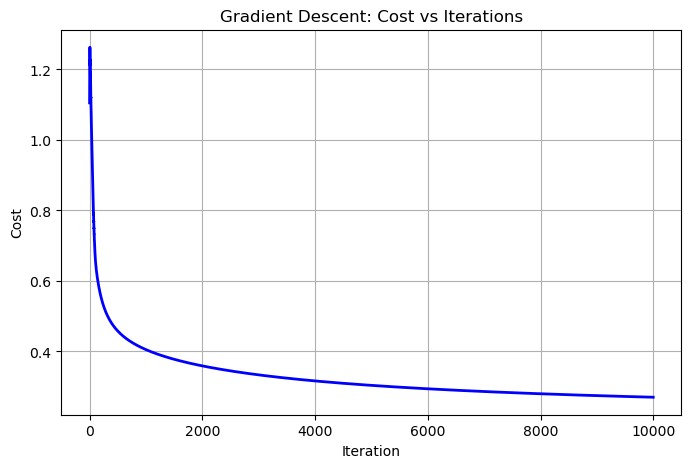

In [22]:
iterations = list(range(len(cost_hist)))  # x-axis
costs = cost_hist                         # y-axis

plt.figure(figsize = (8, 5))
plt.plot(iterations, costs, color = 'blue', linewidth = 2)
plt.title("Gradient Descent: Cost vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

The cost curve drops quickly at the start, showing that gradient descent makes big improvements early on. Around iteration ~1000, there’s an elbow where the cost still decreases but at a much slower rate, meaning the model is approaching its optimal parameters and further learning gives diminishing returns.

### Model Performance

In [23]:
# Prediction Function
def predict(X, w, b):
    z = np.dot(X, w.T) + b
    y_hat = np.exp(z) / np.sum(np.exp(z), axis = 1, keepdims = True)  
    return np.argmax(y_hat, axis = 1)

In [24]:
y_pred = predict(X, w_final, b_final)

accuracy = np.mean(y_pred == y.flatten())
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 89.35%


Using the final trained weights and bias, the model predicts the labels which are matched to the true values using the evaluation metric of accuracy. The result shows that 89.35 % of predictions match with the actual values.